# <font color="#154360"><center>Projet 6 : Réalisez une analyse de sentiments grâce au Deep Learning</center></font>
# <font color="#154360"><center>Partie II - Modèles prédictifs simples</center></font>

## Préambule 
### 1 - Contexte



### 2 - Chargement des librairies

In [1]:
# Version Python
!python --version

Python 3.12.3


In [2]:
# Librairies pour la manipulation de données
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition, cluster, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
import gensim
import transformers
from transformers import AutoTokenizer, TFAutoModel
import re
from mlflow.models import infer_signature
import os

# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Librairies pour la visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pivottablejs import pivot_ui

# Suivi des performances
import mlflow

# Version bibliothèque partiellement importée
import importlib.metadata

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))
print("matplotlib - ", importlib.metadata.version('matplotlib'))


json - 2.0.9
numpy - 1.26.4
pandas - 2.2.2
tensorflow_hub - 0.16.1
tensorflow - 2.18.0
tensorflow - 2.18.0
gensim - 4.3.3
transformers - 4.46.2
re - 2.2.1
seaborn - 0.13.2
mlflow - 2.18.0
matplotlib -  3.9.2


### 3 - Lecture des fichiers

In [3]:
# Lecture des données textuelles
df_tweet_preproc = pd.read_csv('tweet_preproc.csv', encoding="ISO-8859-1")

In [4]:
df_tweet_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596630 entries, 0 to 1596629
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   sentiment        1596630 non-null  object
 1   id               1596630 non-null  int64 
 2   date             1596630 non-null  object
 3   auteur           1596630 non-null  object
 4   tweet            1588667 non-null  object
 5   long_tweet       1596630 non-null  int64 
 6   label sentiment  1596630 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 85.3+ MB


On constate que des tweets sont vides, nous allons donc les supprimer.

In [5]:
# Supprimer les lignes où 'tweet' est vide ou constitué uniquement d'espaces
df_tweet_preproc = df_tweet_preproc[~df_tweet_preproc['tweet'].isnull() & (df_tweet_preproc['tweet'].str.strip() != '')]

# Réinitialiser les index après suppression des lignes
df_tweet_preproc.reset_index(drop=True, inplace=True)

# Vérification
print(f"Nombre de lignes restantes après suppression : {len(df_tweet_preproc)}")

Nombre de lignes restantes après suppression : 1588667


## I - Echantillon de données et fonctions communes
Nous avons un dataset avec énormément de données, nous allons dans un premier temps ne prendre qu'un échantillon pour tester plusieurs approches.

In [6]:
# Taille de l'échantillon
taille_echantillon = 1600 

# Séparation des données 
echantillon_tweet, _ = train_test_split(
    df_tweet_preproc,
    train_size=taille_echantillon,  # On conserve 1% des données
    stratify=df_tweet_preproc["label sentiment"],  # On se base sur la colonne des catégories pour stratifier
    random_state=42  # Pour reproduire les résultats
)

# Vérification
print("Distribution des sentiments :")
print(echantillon_tweet["sentiment"].value_counts(normalize=True))  # Proportions dans les données originales

Distribution des sentiments :
sentiment
négatif    0.5
positif    0.5
Name: proportion, dtype: float64


In [7]:
pivot_ui(echantillon_tweet)

In [8]:
# Paramètres à suivre avec MLFlow
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 42,
}

# Fonction régression logistique
def reg_log_fct(features, labels):
    time1 = time.time()
    
    # 1. Séparation des données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        labels, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    # 2. Création et entraînement du modèle de régression logistique
    logreg = LogisticRegression(**params)
    logreg.fit(X_train, y_train)

    # 3. Prédiction sur l'ensemble de test
    y_pred = logreg.predict(X_test)

    # 4. Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    report = pd.DataFrame(report).transpose()
    time2 = time.time() - time1  # Temps d'exécution
    print("Accuracy :", accuracy)
    print("Classification Report :")
    display(report)
    print("Temps d'exécution :", np.round(time2, 2), "secondes")

    # Calcul de la matrice de confusion
    matrice_conf = confusion_matrix(y_test, y_pred)
    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrice_conf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Étiquettes prédites')
    plt.ylabel('Étiquettes réelles')
    plt.title('Matrice de Confusion des sentiments prédits et réels')
    plt.show()

    return accuracy, report, time2, logreg, X_train

## II - Classification Bag of Words avec Régression Logistique
#### 1 - CountVectorizer

CountVectorizer : 
-----------------
Accuracy : 0.684375
Classification Report :


,precision,recall,f1-score,support
0,0.666667,0.737500,0.700297,160.000000
1,0.706294,0.631250,0.666667,160.000000
accuracy,0.684375,0.684375,0.684375,0.684375
macro avg,0.686480,0.684375,0.683482,320.000000
weighted avg,0.686480,0.684375,0.683482,320.000000


Temps d'exécution : 0.04 secondes


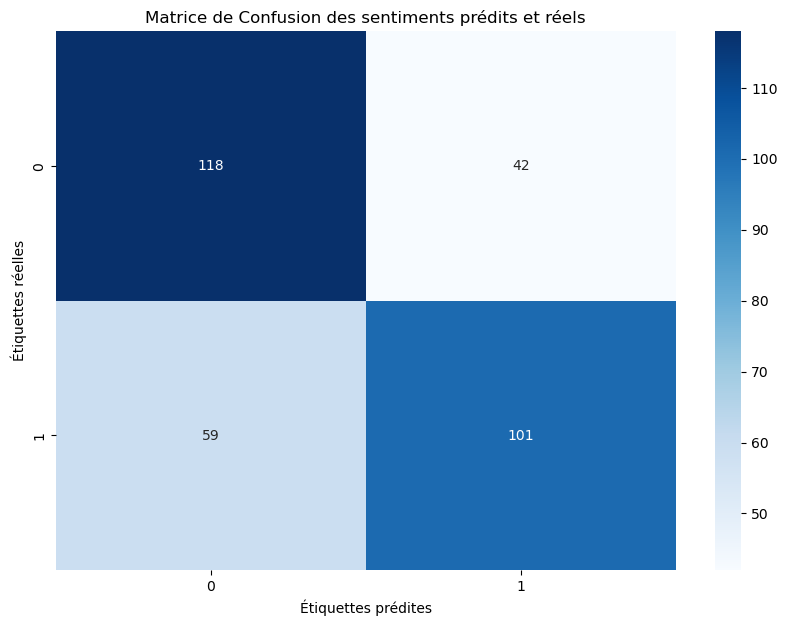

In [9]:
# Initialisation du CountVectorizer
count_vect = CountVectorizer(max_df=0.95, min_df=1)

# Entrainement de notre modèle sur la variable textuelle
cv_fit_transform = count_vect.fit_transform(echantillon_tweet["tweet"])

# Labels réels des sentiments
labels = echantillon_tweet["label sentiment"]  # Labels des sentiments

# Exécution du modèle avec la fonction reg_log_fct
print("CountVectorizer : ")
print("-----------------")
accuracy_cv, report_cv, exec_time_cv, logreg_cv, X_train_cv = reg_log_fct(cv_fit_transform, labels)

### 2 - Tf-idf

Tf-idf : 
-----------------
Accuracy : 0.671875
Classification Report :


,precision,recall,f1-score,support
0,0.657143,0.718750,0.686567,160.000000
1,0.689655,0.625000,0.655738,160.000000
accuracy,0.671875,0.671875,0.671875,0.671875
macro avg,0.673399,0.671875,0.671152,320.000000
weighted avg,0.673399,0.671875,0.671152,320.000000


Temps d'exécution : 0.01 secondes


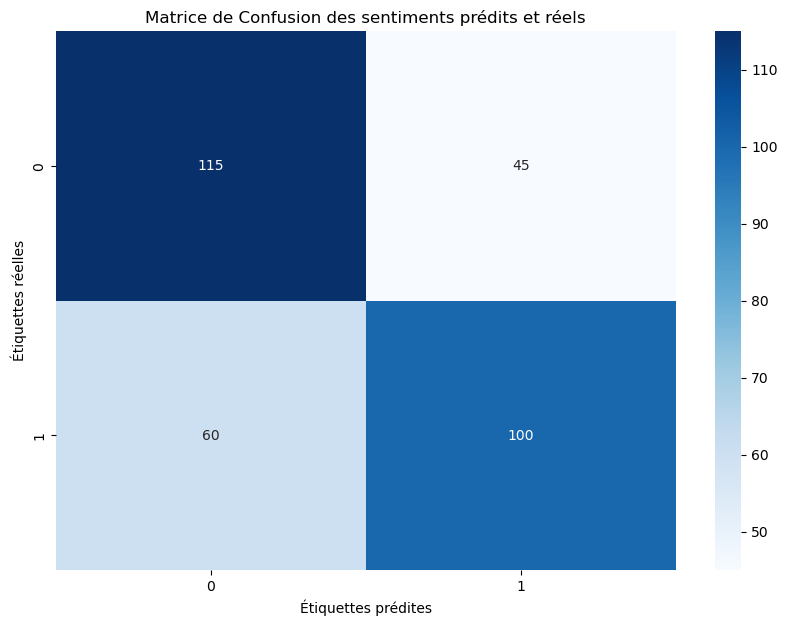

In [10]:
# Initialisation du Tf-idf
tfidf = TfidfVectorizer(max_df=0.95, min_df=1)

# Entrainement de notre modèle sur la variable textuelle
tfidf_fit_transform = tfidf.fit_transform(echantillon_tweet["tweet"])

# Exécution du modèle avec la fonction ARI_fct
print("Tf-idf : ")
print("-----------------")
accuracy_tf, report_tf, exec_time_tf, logreg_tf, X_train_tf = reg_log_fct(tfidf_fit_transform, labels)

## III - Tracking
### 1 - CountVectorizer

In [11]:
# Configurez l'URI de tracking dans MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Bag of Words")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_cv)
    mlflow.log_metric("Temps", exec_time_cv)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Régression Logist")

    # Infer the model signature
    signature = infer_signature(X_train_cv, logreg_cv.predict(X_train_cv))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=logreg_cv,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_cv,
        registered_model_name="CountVectorizer_RegLog",
    )

2025/01/23 15:26:51 INFO mlflow.tracking.fluent: Experiment with name 'Projet 7 - Bag of Words' does not exist. Creating a new experiment.


Successfully registered model 'CountVectorizer_RegLog'.
2025/01/23 15:27:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CountVectorizer_RegLog, version 1


🏃 View run mercurial-moth-239 at: http://127.0.0.1:5000/#/experiments/550376553196193512/runs/af67c0521a0f45c5ba119996c624782c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/550376553196193512


Created version '1' of model 'CountVectorizer_RegLog'.


### 2 - Tf-idf

In [12]:
# Create a new MLflow Experiment
mlflow.set_experiment("Projet 7 - Bag of Words")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("Accuracy", accuracy_tf)
    mlflow.log_metric("Temps", exec_time_tf)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Régression Logistique")

    # Infer the model signature
    signature = infer_signature(X_train_tf, logreg_tf.predict(X_train_tf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=logreg_tf,
        artifact_path="tweet_model",
        signature=signature,
        input_example=X_train_tf,
        registered_model_name="Tf-idf_RegLog",
    )

Successfully registered model 'Tf-idf_RegLog'.
2025/01/23 15:27:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Tf-idf_RegLog, version 1


🏃 View run dazzling-dolphin-908 at: http://127.0.0.1:5000/#/experiments/550376553196193512/runs/e602c9e0140649f9a460af5007d26a85
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/550376553196193512


Created version '1' of model 'Tf-idf_RegLog'.


## Conclusion